In [ ]:
# monter Google Drive pour accéder aux données d'entraînement stockées dans un dossier.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prepare paths

In [ ]:
import os

input_dir = "/content/drive/MyDrive/3P_IIA3/training/trainingNodules/"
target_dir = "/content/drive/MyDrive/3P_IIA3/training/trainingMask/"
img_size = (64, 64) #Taille des images redimensionnées en (largeur, hauteur). Toutes les images seront converties en cette dimension pour être compatibles avec le modèle.
num_classes = 2     #Nombre de classes dans le modèle (segmentation binaire : présence ou absence de nodule)
batch_size = 32     #Nombre d'images par lot.

# sorted(...) : Trie les chemins de manière lexicographique pour garantir l'alignement entre les images et les masques
input_img_paths = sorted(
    [
        #Combine le chemin du répertoire (input_dir) avec le nom du fichier (fname) pour obtenir le chemin complet
        os.path.join(input_dir, fname)
        #Récupère tous les noms de fichiers dans le dossier input_dir
        for fname in os.listdir(input_dir)
        #Filtre uniquement les fichiers se terminant par .jpg
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

#Affiche le nombre d’images d’entrée disponibles dans input_dir (correspondant normalement au nombre de masques dans target_dir)
print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 9214
/content/drive/MyDrive/3P_IIA3/training/trainingNodules/LIDC-IDRI-0001_0_0_5.jpg | /content/drive/MyDrive/3P_IIA3/training/trainingMask/LIDC-IDRI-0001_0_0_5.jpg
/content/drive/MyDrive/3P_IIA3/training/trainingNodules/LIDC-IDRI-0001_0_1_5.jpg | /content/drive/MyDrive/3P_IIA3/training/trainingMask/LIDC-IDRI-0001_0_1_5.jpg
/content/drive/MyDrive/3P_IIA3/training/trainingNodules/LIDC-IDRI-0001_0_2_5.jpg | /content/drive/MyDrive/3P_IIA3/training/trainingMask/LIDC-IDRI-0001_0_2_5.jpg
/content/drive/MyDrive/3P_IIA3/training/trainingNodules/LIDC-IDRI-0001_0_3_5.jpg | /content/drive/MyDrive/3P_IIA3/training/trainingMask/LIDC-IDRI-0001_0_3_5.jpg
/content/drive/MyDrive/3P_IIA3/training/trainingNodules/LIDC-IDRI-0001_0_4_5.jpg | /content/drive/MyDrive/3P_IIA3/training/trainingMask/LIDC-IDRI-0001_0_4_5.jpg
/content/drive/MyDrive/3P_IIA3/training/trainingNodules/LIDC-IDRI-0001_0_5_5.jpg | /content/drive/MyDrive/3P_IIA3/training/trainingMask/LIDC-IDRI-0001_0_5_5.jpg
/content/d

In [ ]:
pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


What does one input image and corresponding segmentation mask look like?

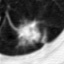

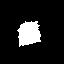

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.utils import load_img  #Renvoie une image sous forme d'objet PIL (Python Imaging Library), ce qui permet de la manipuler ou de l'afficher facilement
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[7]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)

Prepare Sequence class to load & vectorize batches of data

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img,img_to_array
# img_to_array : Convertit une image PIL en tableau NumPy

# Générateur de données pour les modèles TensorFlow.
# Elle permet de charger les images par lots au cours de l'entraînement, en minimisant la charge mémoire
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    # nombre total de lots dans l'ensemble des données
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = img_to_array(img)
            y[j] = np.where(img>128,1,0)
            #y[j] = np.expand_dims(img, 2)
            #y[j] -= 1
        return x, y

build unet

In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,)) #La taille d'entrée est (img_height, img_width, 3) : 3 pour RGB

    ### [First half of the network: downsampling inputs (Réduction de la résolution)] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:  # filter : noyau ou kernel
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model2 = get_model(img_size, num_classes)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 32)   0           ['batch_normalization[0][0]']

Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 4000
random.Random(2000).shuffle(input_img_paths)
random.Random(2000).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)



Train the model



In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

import tensorflow.keras.backend as K

#sensibilité (ou recall) calcule le taux de vrais positifs
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

#coefficient de Dice mesure la similarité entre deux ensembles(reeles et predites)
def dice_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2 * intersection + K.epsilon()) / (union + K.epsilon())

import tensorflow as tf
metrics = ["accuracy", sensitivity, dice_coefficient]
optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4)
# loss adaptée pour des classes avec des étiquettes entières (et non des one-hot encodings)
model2.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=metrics)

#callbacks = [
  #  keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
#]

# Train the model, doing validation at the end of each epoch.
epochs = 10
modelunet= model2.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/10
162/162 [==============================] - 415s 2s/step - loss: 0.0973 - accuracy: 0.9674 - sensitivity: 1.0000 - dice_coefficient: 0.0726 - val_loss: 0.1297 - val_accuracy: 0.9940 - val_sensitivity: 1.0000 - val_dice_coefficient: 0.0729
Epoch 2/10
162/162 [==============================] - 436s 3s/step - loss: 0.0547 - accuracy: 0.9671 - sensitivity: 1.0000 - dice_coefficient: 0.0726 - val_loss: 0.1223 - val_accuracy: 0.9985 - val_sensitivity: 1.0000 - val_dice_coefficient: 0.0729
Epoch 3/10
162/162 [==============================] - 483s 3s/step - loss: 0.0425 - accuracy: 0.9665 - sensitivity: 1.0000 - dice_coefficient: 0.0726 - val_loss: 0.0895 - val_accuracy: 0.9910 - val_sensitivity: 1.0000 - val_dice_coefficient: 0.0729
Epoch 4/10
162/162 [==============================] - 418s 3s/step - loss: 0.0349 - accuracy: 0.9655 - sensitivity: 1.0000 - dice_coefficient: 0.0726 - val_loss: 0.0557 - val_accuracy: 0.9754 - val_sensitivity: 1.0000 - val_dice_coefficient: 0.0729
Epoc

Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set

import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import ImageOps
from IPython.display import Image, display
import shutil

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model2.predict(val_gen)


125/125 [==============================] - 82s 652ms/step


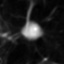

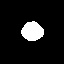

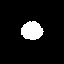

In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image
i = 4

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.


PATH_DATABASE ='/content/drive/MyDrive/evaluation/'

PATH_NODULE_UNET_IMAGE = PATH_DATABASE + 'evaluation_nodules/'
PATH_NODULE_MASK_UNET_IMAGE = PATH_DATABASE + 'evaluation_mask/'
PATH_NODULE_MASK_GENERATED_UNET_IMAGE = PATH_DATABASE + 'mask_unet/'

dir_unet_nodule = PATH_NODULE_UNET_IMAGE
dir_unet_mask = PATH_NODULE_MASK_UNET_IMAGE
dir_unet_generated_mask = PATH_NODULE_MASK_GENERATED_UNET_IMAGE

for i in range(len(val_preds)):

    filelocation = val_input_img_paths[i]
    maskLocation = val_target_img_paths[i]

    #Extrait le nom du fichier à partir du chemin complet.
    filename = filelocation.split(os.path.sep)[-1]

    label = filename[-5:-4]
    if label in '12' :
        label = '1'
    elif label in '45' :
        label = '2'
    else :
        label = '0'

    imgnod = dir_unet_nodule + '\\' +  label + filename
    shutil.copy2(filelocation,imgnod)

    imgnodmask = dir_unet_mask + '\\' +  label + filename
    shutil.copy2(maskLocation,imgnodmask)

    imgunetmask = dir_unet_generated_mask+ '\\' + label + filename
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    img.save(imgunetmask)






Visualize figure Loss & Accuracy

In [ ]:
import matplotlib
matplotlib.use("Agg")


loss = modelunet.history['loss']
val_loss =modelunet.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('/content/drive/MyDrive/evaluation/fig.png')
plt.show()

plt.figure()
plt.plot(modelunet.history['accuracy'])
plt.plot(modelunet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/evaluation/figAcc.png')
plt.show()


Performence

In [ ]:
import numpy as np
import keras as k
import numpy as np
import keras as k

import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2 * intersection + K.epsilon()) / (union + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    actual_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (actual_positives + K.epsilon())

def iou_coef(save_images,test_y):
    intersection = K.sum(save_images*test_y)
    sum = K.sum(save_images+test_y)
    iou = (intersection ) / (sum - intersection )
    return iou

test

In [ ]:

val_input_img_paths='/content/drive/MyDrive/testing/nodules'
val_target_img_paths='/content/drive/MyDrive/testing/mask'

input_img_paths = sorted(
    [
        os.path.join(val_input_img_paths, fname)
        for fname in os.listdir(val_input_img_paths)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(val_target_img_paths, fname)
        for fname in os.listdir(val_target_img_paths)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

val_gen = OxfordPets(batch_size, img_size, input_img_paths, target_img_paths)
val_preds = model2.predict(val_gen)

128/128 [==============================] - 116s 904ms/step


In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image
i = 4

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

PATH_DATABASE ='/content/drive/MyDrive/testing/'

PATH_NODULE_UNET_IMAGE = PATH_DATABASE + 'nodules/'
PATH_NODULE_MASK_UNET_IMAGE = PATH_DATABASE + 'mask/'
PATH_NODULE_MASK_GENERATED_UNET_IMAGE = PATH_DATABASE + 'PredectionForEvaluation/'

dir_unet_nodule = PATH_NODULE_UNET_IMAGE
dir_unet_mask = PATH_NODULE_MASK_UNET_IMAGE
dir_unet_generated_mask = PATH_NODULE_MASK_GENERATED_UNET_IMAGE



for i in range(len(val_preds)):

    filelocation = val_input_img_paths[i]
    maskLocation = val_target_img_paths[i]

    filename = filelocation.split(os.path.sep)[-1]

    label = filename[-5:-4]
    if label in '12' :
        label = '1'
    elif label in '45' :
        label = '2'
    else :
        label = '0'

    imgnod = dir_unet_nodule + '\\' +  label + filename
    shutil.copy2(filelocation,imgnod)

    imgnodmask = dir_unet_mask + '\\' +  label + filename
    shutil.copy2(maskLocation,imgnodmask)

    imgunetmask = dir_unet_generated_mask+ '\\' + label + filename
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    img.save(imgunetmask)






In [ ]:
import os
from PIL import Image
from os import listdir
import keras as k
evaluation_mask='/content/drive/MyDrive/evaluation/evaluation_mask'
mask_unet='/content/drive/MyDrive/evaluation/mask_unet'
dices  = []
sensitivities=[]
iuo =[]

for image_file in os.listdir(evaluation_mask):
    for pred_file in os.listdir(mask_unet):
        image_path = os.path.join(evaluation_mask, image_file)
        pred_path = os.path.join(mask_unet, pred_file)

        dices.append(dice_coefficient(pred_path, image_path))
        sensitivities.append(sensitivity(pred_path, image_path))
        iuo.append(iou_coef(pred_path, image_path))

TypeError: ignored